In [133]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [134]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os
from google.colab.patches import cv2_imshow

In [135]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


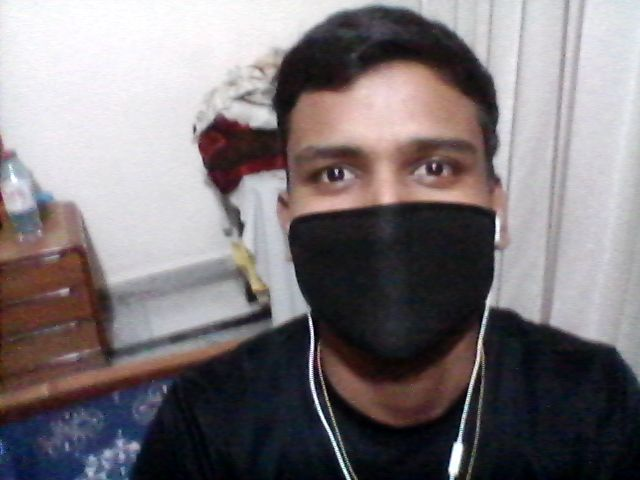

In [143]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  display(Image(filename))
except Exception as err:
  print(str(err))


In [144]:
prototxtPath = os.path.sep.join([r'drive/My Drive/face_detector','deploy.prototxt'])
weightsPath = os.path.sep.join([r'drive/My Drive/face_detector','res10_300x300_ssd_iter_140000.caffemodel'])

In [145]:
net = cv2.dnn.readNet(prototxtPath,weightsPath)

In [146]:
model = load_model(r'drive/My Drive/face_mask_detection.model')

In [147]:
image = cv2.imread(filename)
(h,w) = image.shape[:2]
blob = cv2.dnn.blobFromImage(image,1.0,(300,300),(104.0,177.0,123.0))

In [148]:
net.setInput(blob)
detections = net.forward()

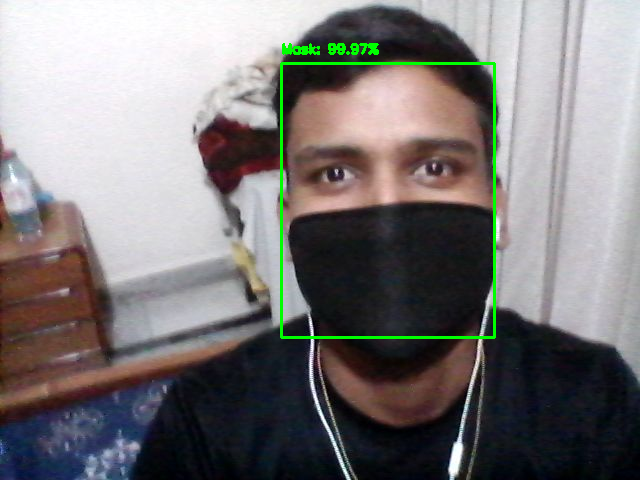

In [149]:
for i in range(0,detections.shape[2]):

  confidence = detections[0,0,i,2]
  
  if confidence > 0.5:
    box = detections[0,0,i,3:7]*np.array([w,h,w,h])
    (startX,startY,endX,endY) = box.astype('int')

    (startX,startY) = (max(0,startX),max(0,startY))
    (endX,endY) = (min(w-1,endX),min(h-1,endY))

    face = image[startY:endY,startX:endX]
    face = cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
    face = cv2.resize(face,(224,224))
    face = img_to_array(face)
    face = preprocess_input(face)
    face = np.expand_dims(face,axis=0)

    (mask,withoutMask) = model.predict(face)[0]

    label='Mask' if mask>withoutMask else 'No Mask'
    color = (0,255,0) if label == 'Mask'  else (0,0,255)

    label="{}: {:.2f}%".format(label,max(mask,withoutMask)*100)

    cv2.putText(image,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
    cv2.rectangle(image,(startX,startY),(endX,endY),color,2)


cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()